In [1]:
%matplotlib inline
import os
import glob
import csv
import re
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import pywt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from mpl_toolkits.mplot3d import Axes3D 
from scipy import signal
from scipy.signal import find_peaks
from scipy import optimize
from scipy.stats import linregress, stats
import seaborn as sns

import datetime as dt
from textwrap import wrap


# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
os.getcwd()

'C:\\Users\\bina_\\Dropbox\\Robina Shaheen_PEMS2022\\PEMS_NOx_BC_CO2_ALPR\\ii.dwt'

In [2]:
df1 = pd.read_csv('./Results2/full_NO2_HWpeak.csv')
del df1[df1.columns[0]]
df1.head()
# # df1.drop(['unnamed'], axis=1)
# del df1[df1.columns[0]]
# df1.drop(df1.columns[[0, 7]], axis=1, inplace=True)
# print(df1.head())
# print(df2.head())
# print(len(df1))
# print(len(df2))
# print(df2.dtypes)

,0,1,2,3,4,5,6,7,8,9,...,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021
0,63.302494,53.738099,10.494250,24.884789,8.373713,87.581633,55.749488,33.188837,51.747280,25.846455,...,74.596635,114.916017,55.067632,57.821061,141.011931,225.099301,61.275678,60.153093,67.578423,9.629466
1,1.033081,1.007554,0.999950,1.002024,1.001126,1.006777,1.008563,1.006683,1.035778,1.061580,...,0.999404,1.157926,1.054013,1.030845,1.037865,1.030563,1.025611,1.001729,0.999735,1.013513
2,22.336441,162.145859,240.868285,284.548500,336.838200,397.011620,533.439700,692.569225,940.073184,1152.572277,...,144251.147220,144413.834927,144602.317803,144735.816932,144894.360349,145291.511615,145616.811621,145762.928338,145953.494911,146175.450004
3,85.638936,215.883958,251.362535,309.433289,345.211913,484.593253,589.189188,725.758062,991.820465,1178.418732,...,144325.743856,144528.750944,144657.385435,144793.637993,145035.372280,145516.610917,145678.087299,145823.081432,146021.073334,146185.079471


In [3]:
df2=df1.transpose()
df2.head()

,0,1,2,3
0,63.302494,1.033081,22.336441,85.638936
1,53.738099,1.007554,162.145859,215.883958
2,10.494250,0.999950,240.868285,251.362535
3,24.884789,1.002024,284.548500,309.433289
4,8.373713,1.001126,336.838200,345.211913


In [4]:
df2.rename(columns={0:'HW_NO2', 1:'peak_height', 
                    2: 'Ti',3: 'Tf'  }, inplace=True)
df2.head(3)

,HW_NO2,peak_height,Ti,Tf
0,63.302494,1.033081,22.336441,85.638936
1,53.738099,1.007554,162.145859,215.883958
2,10.494250,0.999950,240.868285,251.362535


In [5]:
df2["Area_NO2"] = df2["HW_NO2"] * df2['peak_height']
df2.head()

,HW_NO2,peak_height,Ti,Tf,Area_NO2
0,63.302494,1.033081,22.336441,85.638936,65.396600
1,53.738099,1.007554,162.145859,215.883958,54.144052
2,10.494250,0.999950,240.868285,251.362535,10.493724
3,24.884789,1.002024,284.548500,309.433289,24.935164
4,8.373713,1.001126,336.838200,345.211913,8.383146


In [38]:
df2["NO2 (ng/m3)"] = (df2["Area_NO2"] * 46)/24.45
df2['NO2 (ug/m3)'] = (df2['NO2 (ng/m3)']/1000)
df2.rename(columns={'Ti':'t1_indexed'}, inplace=True)
print(len(df2))
print(df2.dtypes)
df2.head()

1022
HW_NO2         float64
peak_height    float64
t1_indexed     float64
Tf             float64
Area_NO2       float64
NO2 ng/m3      float64
NO2 (ng/m3)    float64
NO2 (ug/m3)    float64
dtype: object


,HW_NO2,peak_height,t1_indexed,Tf,Area_NO2,NO2 ng/m3,NO2 (ng/m3),NO2 (ug/m3)
0,63.302494,1.033081,22.336441,85.638936,65.396600,123.036549,123.036549,0.123037
1,53.738099,1.007554,162.145859,215.883958,54.144052,101.866110,101.866110,0.101866
2,10.494250,0.999950,240.868285,251.362535,10.493724,19.742793,19.742793,0.019743
3,24.884789,1.002024,284.548500,309.433289,24.935164,46.912783,46.912783,0.046913
4,8.373713,1.001126,336.838200,345.211913,8.383146,15.771971,15.771971,0.015772


In [39]:
df = pd.read_csv('./Results2/NO2_ppb_denoised_recon_s6_t.csv')
print(len(df))
df.head()

146188


,Unnamed: 0,Approx_6,time2
0,0,1.000414,00:00:00.806918
1,1,1.001394,00:00:01.205161
2,2,1.002434,00:00:02.001646
3,3,1.003530,00:00:02.303072
4,4,1.004680,00:00:02.813103


In [40]:
df.rename(columns={'Unnamed: 0':'t1_indexed'}, inplace=True)
# df1.columns
print(df.dtypes)
df.head()

t1_indexed      int64
Approx_6      float64
time2          object
dtype: object


,t1_indexed,Approx_6,time2
0,0,1.000414,00:00:00.806918
1,1,1.001394,00:00:01.205161
2,2,1.002434,00:00:02.001646
3,3,1.003530,00:00:02.303072
4,4,1.004680,00:00:02.813103


In [41]:
df['t1_indexed'] = df['t1_indexed'].astype(float)
df.dtypes

t1_indexed    float64
Approx_6      float64
time2          object
dtype: object

In [42]:
df.sort_values(by='t1_indexed', inplace=True)
df2.sort_values(by='t1_indexed', inplace=True)
print(len(df2))
print(len(df))

1022
146188


In [43]:
df3= pd.merge_asof(
    df2, df, on="t1_indexed",direction="nearest",  
        allow_exact_matches=False)
print(len(df3))

df3.head()

1022


,HW_NO2,peak_height,t1_indexed,Tf,Area_NO2,NO2 ng/m3,NO2 (ng/m3),NO2 (ug/m3),Approx_6,time2
0,63.302494,1.033081,22.336441,85.638936,65.396600,123.036549,123.036549,0.123037,1.032521,00:00:11.090862
1,53.738099,1.007554,162.145859,215.883958,54.144052,101.866110,101.866110,0.101866,1.007421,00:03:06.156757
2,10.494250,0.999950,240.868285,251.362535,10.493724,19.742793,19.742793,0.019743,0.999954,00:03:44.279863
3,24.884789,1.002024,284.548500,309.433289,24.935164,46.912783,46.912783,0.046913,1.002099,00:04:05.900314
4,8.373713,1.001126,336.838200,345.211913,8.383146,15.771971,15.771971,0.015772,1.001128,00:04:31.522995


In [44]:
df3.to_csv('./Results2/NO2_peakarea_time_indexed.csv')

In [45]:
df_CO2_peak = pd.read_csv('./Results2/merged_CO2_EF_index.csv', index_col=0)
print(len(df_CO2_peak))
df_CO2_peak.dtypes

486


HW_CO2         float64
peak_height    float64
t1_indexed     float64
Tf             float64
Area_CO2       float64
CO2 (ug/m3)    float64
CO2 EF         float64
Conc. CO2      float64
time2           object
dtype: object

In [46]:
df_CO2_peak.sort_values(by='t1_indexed', inplace=True)
df3.sort_values(by='t1_indexed', inplace=True)
print(len(df_CO2_peak))
print(len(df3))>

SyntaxError: invalid syntax (<ipython-input-46-e6e0fc20c469>, line 4)

In [47]:
df4= pd.merge_asof(
    df_CO2_peak,df3,  on="t1_indexed",direction="nearest",  
        allow_exact_matches=False)
print(len(df4))
# df4.to_csv('./Results2/merged_CO2_NO2_TS_index.csv')
df4.head()

486


,HW_CO2,peak_height_x,t1_indexed,Tf_x,Area_CO2,CO2 (ug/m3),CO2 EF,Conc. CO2,time2_x,HW_NO2,peak_height_y,Tf_y,Area_NO2,NO2 ng/m3,NO2 (ng/m3),NO2 (ug/m3),Approx_6,time2_y
0,126.247273,368.902634,230.964721,357.211993,46572.951467,83812.264399,264285.213329,368.904678,0:05:40,10.494250,0.999950,251.362535,10.493724,19.742793,19.742793,0.019743,0.999954,00:03:44.279863
1,38.526629,367.884608,406.558750,445.085379,14173.353748,25506.239873,80428.826192,367.897092,0:08:36,87.581633,1.006777,484.593253,88.175197,165.891987,165.891987,0.165892,1.006775,00:05:01.228321
2,113.538243,367.910378,541.237969,654.776212,41771.897940,75172.331671,237040.913457,367.887545,0:10:50,55.749488,1.008563,589.189188,56.226877,105.784718,105.784718,0.105785,1.008462,00:06:08.130517
3,69.130348,376.305601,798.237072,867.367420,26014.137202,46814.807235,147621.131654,376.272816,0:15:07,33.188837,1.006683,725.758062,33.410624,62.858435,62.858435,0.062858,1.006712,00:07:26.768668
4,11.339629,373.332662,928.733648,940.073276,4233.453754,7618.485284,24023.369645,373.336148,0:17:18,51.747280,1.035778,991.820465,53.598707,100.840104,100.840104,0.100840,1.035766,00:09:28.202367


In [70]:
df4["NO2/CO2 EF/kg fuel"] = (df4["NO2 (ug/m3)"]/df4["CO2 (ug/m3)"])* 3.1533*1000
# df4.to_csv('./Results2/merged_CO2_NO2_EF.csv')
df4.head()

,HW_CO2,peak_height_x,t1_indexed,Tf_x,Area_CO2,CO2 (ug/m3),CO2 EF,Conc. CO2,time2_x,HW_NO2,...,NO2 ng/m3,NO2 (ng/m3),NO2 (ug/m3),Approx_6,time2_y,NOx/CO2 EF/kg fuel,time,minutes,seconds,NO2/CO2 EF/kg fuel
0,126.247273,368.902634,230.964721,357.211993,46572.951467,83812.264399,264285.213329,368.904678,0:05:40,10.494250,...,19.742793,19.742793,0.019743,0.999954,00:03:44.279863,1.338641e+10,2022-11-28 00:05:40,5.666667,45,0.000743
1,38.526629,367.884608,406.558750,445.085379,14173.353748,25506.239873,80428.826192,367.897092,0:08:36,87.581633,...,165.891987,165.891987,0.165892,1.006775,00:05:01.228321,4.848265e+08,2022-11-28 00:08:36,8.600000,44,0.020509
2,113.538243,367.910378,541.237969,654.776212,41771.897940,75172.331671,237040.913457,367.887545,0:10:50,55.749488,...,105.784718,105.784718,0.105785,1.008462,00:06:08.130517,2.240786e+09,2022-11-28 00:10:50,10.833333,60,0.004437
3,69.130348,376.305601,798.237072,867.367420,26014.137202,46814.807235,147621.131654,376.272816,0:15:07,33.188837,...,62.858435,62.858435,0.062858,1.006712,00:07:26.768668,2.348470e+09,2022-11-28 00:15:07,15.116667,22,0.004234
4,11.339629,373.332662,928.733648,940.073276,4233.453754,7618.485284,24023.369645,373.336148,0:17:18,51.747280,...,100.840104,100.840104,0.100840,1.035766,00:09:28.202367,2.382323e+08,2022-11-28 00:17:18,17.300000,35,0.041738


In [71]:
##Check how these cells were filled despite difference in number
print('Empty cells/ zero values:', df4.isnull().sum())

Empty cells/ zero values: HW_CO2                0
peak_height_x         0
t1_indexed            0
Tf_x                  0
Area_CO2              0
CO2 (ug/m3)           0
CO2 EF                0
Conc. CO2             0
time2_x               0
HW_NO2                0
peak_height_y         0
Tf_y                  0
Area_NO2              0
NO2 ng/m3             0
NO2 (ng/m3)           0
NO2 (ug/m3)           0
Approx_6              0
time2_y               0
NOx/CO2 EF/kg fuel    0
time                  0
minutes               0
seconds               0
NO2/CO2 EF/kg fuel    0
dtype: int64


In [82]:
df4[['time']] = df4[['time2_x']].apply(pd.to_datetime)
df4['minutes'] = df4['time'].dt.hour * 60 + df4['time'].dt.minute + df4['time'].dt.second/60
df4['seconds'] = df4['time'].dt.hour * 60 + df4['time'].dt.minute + df4['time'].dt.second
df4.to_csv('./Results2/merged_CO2_NO2_EF_time_min.csv')
print(df4.dtypes)

df4.head(2)

HW_CO2                       float64
peak_height_x                float64
t1_indexed                   float64
Tf_x                         float64
Area_CO2                     float64
CO2 (ug/m3)                  float64
CO2 EF                       float64
Conc. CO2                    float64
time2_x                       object
HW_NO2                       float64
peak_height_y                float64
Tf_y                         float64
Area_NO2                     float64
NO2 ng/m3                    float64
NO2 (ng/m3)                  float64
NO2 (ug/m3)                  float64
Approx_6                     float64
time2_y                       object
NOx/CO2 EF/kg fuel           float64
time                  datetime64[ns]
minutes                      float64
seconds                        int64
NO2/CO2 EF/kg fuel           float64
dtype: object


,HW_CO2,peak_height_x,t1_indexed,Tf_x,Area_CO2,CO2 (ug/m3),CO2 EF,Conc. CO2,time2_x,HW_NO2,...,NO2 ng/m3,NO2 (ng/m3),NO2 (ug/m3),Approx_6,time2_y,NOx/CO2 EF/kg fuel,time,minutes,seconds,NO2/CO2 EF/kg fuel
0,126.247273,368.902634,230.964721,357.211993,46572.951467,83812.264399,264285.213329,368.904678,0:05:40,10.494250,...,19.742793,19.742793,0.019743,0.999954,00:03:44.279863,1.338641e+10,2022-11-28 00:05:40,5.666667,45,0.000743
1,38.526629,367.884608,406.558750,445.085379,14173.353748,25506.239873,80428.826192,367.897092,0:08:36,87.581633,...,165.891987,165.891987,0.165892,1.006775,00:05:01.228321,4.848265e+08,2022-11-28 00:08:36,8.600000,44,0.020509


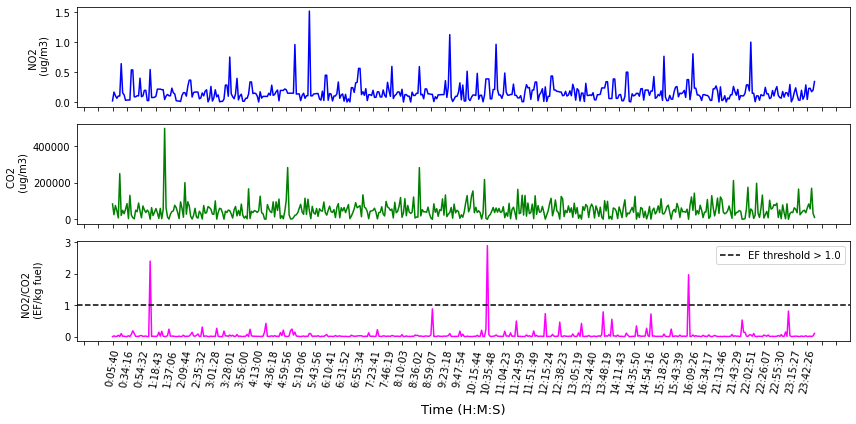

In [107]:
fig, (ax1, ax2, ax3,) = plt.subplots(3, 1, 
                    sharex=True, figsize=(12, 6))
# Add x-axis and y-axis
ax1.plot(df4['time2_x'],
         df4['NO2 (ug/m3)'],
         color='blue')
# ax2.plot(app2.index.values,
#        app2['Approx_2'],
#        color='orange')

ax2.plot(df4['time2_x'],
         df4['CO2 (ug/m3)'],
         color='green')
ax3.plot(df4['time2_x'],
         df4['NO2/CO2 EF/kg fuel'],
         color='magenta')

# ax5.plot(BC.index.values,
#          BC['BC_app_3'],
#          color='black')

ax1.set(
    ylabel=" NO2  \n (ug/m3)")
# ax2.set(ylabel=" App. L2")
ax2.set(ylabel="CO2  \n (ug/m3)")
ax3.set(ylabel="NO2/CO2  \n (EF/kg fuel)"),
ax3.yaxis.labelpad = 20
plt.axhline(y = 1.0, color = 'black', linestyle = 'dashed', 
            label = "EF threshold > 1.0")
# plt.plot(x_array, y_array)
plt.xticks(rotation =80) # Rotates X-Axis Ticks by 45-degrees
# plt.grid(b=True, which='major', color='grey', linestyle='--')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(3))
# line colour is red
  
# plotting the legend
plt.legend()
plt.xlabel('Time (H:M:S)', fontsize = 13, labelpad = 10)

plt.tight_layout()
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))
plt.savefig('./Results2/NO2_CO2_EF_comparison.png')
plt.show()



In [83]:

df_lic = pd.read_csv('./Results2/simplified_ALPR.csv', index_col=0)
print(len(df_lic))
print(df_lic.head)
# print(dtypes(df_lic))

1738
<bound method NDFrame.head of                      Time     time2     license vehicle-make-name
0     2022-09-02 00:00:19  00:00:19  2102015672         chevrolet
1     2022-09-02 00:48:47  00:48:47  2104921995             volvo
2     2022-09-02 00:48:56  00:48:56  2104932924              ford
3     2022-09-02 00:49:11  00:49:11  2104946538         chevrolet
4     2022-09-02 00:49:11  00:49:11  2104947077          kenworth
...                   ...       ...         ...               ...
1733  2022-09-02 23:20:55  23:20:55  2186051819             dodge
1734  2022-09-02 23:45:44  23:45:44  2187540484         chevrolet
1735  2022-09-02 23:45:56  23:45:56  2187552584          kenworth
1736  2022-09-02 23:46:24  23:46:24  2187580106              ford
1737  2022-09-02 23:46:40  23:46:40  2187595624             honda

[1738 rows x 4 columns]>


In [84]:
print(df_lic.dtypes)
print(len(df_lic))

Time                 object
time2                object
license               int64
vehicle-make-name    object
dtype: object
1738


In [85]:
df_lic.rename(columns={'time2':'t1_indexed'}, inplace=True)
# df2.rename(columns={'index':'t1_indexed'}, inplace=True)
# df1.columns
print(df_lic.dtypes)
df_lic.info()

Time                 object
t1_indexed           object
license               int64
vehicle-make-name    object
dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1738 entries, 0 to 1737
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               1738 non-null   object
 1   t1_indexed         1738 non-null   object
 2   license            1738 non-null   int64 
 3   vehicle-make-name  1738 non-null   object
dtypes: int64(1), object(3)
memory usage: 67.9+ KB


In [86]:
df_lic[['t1_indexed']] = df_lic[['t1_indexed']].apply(pd.to_datetime)
# #.apply(lambda x: x.value)
print(df_lic.dtypes)
df_lic.head()

Time                         object
t1_indexed           datetime64[ns]
license                       int64
vehicle-make-name            object
dtype: object


,Time,t1_indexed,license,vehicle-make-name
0,2022-09-02 00:00:19,2022-11-28 00:00:19,2102015672,chevrolet
1,2022-09-02 00:48:47,2022-11-28 00:48:47,2104921995,volvo
2,2022-09-02 00:48:56,2022-11-28 00:48:56,2104932924,ford
3,2022-09-02 00:49:11,2022-11-28 00:49:11,2104946538,chevrolet
4,2022-09-02 00:49:11,2022-11-28 00:49:11,2104947077,kenworth


In [98]:

df_lic['t1_indexed'] = pd.to_datetime(df_lic['t1_indexed'])
df_lic['minutes'] = df_lic['t1_indexed'].dt.hour * 60 + df_lic['t1_indexed'].dt.minute + df_lic['t1_indexed'].dt.second/60
df_lic['seconds'] = df_lic['t1_indexed'].dt.hour * 60 + df_lic['t1_indexed'].dt.minute + df_lic['t1_indexed'].dt.second

print(df_lic.dtypes)
df_lic.head(2)


Time                         object
t1_indexed           datetime64[ns]
license                       int64
vehicle-make-name            object
seconds                       int64
minutes                     float64
dtype: object


,Time,t1_indexed,license,vehicle-make-name,seconds,minutes
0,2022-09-02 00:00:19,2022-11-28 00:00:19,2102015672,chevrolet,19,0.316667
1,2022-09-02 00:48:47,2022-11-28 00:48:47,2104921995,volvo,95,48.783333


In [91]:
df4.sort_values(by='minutes', inplace=True)
df_lic.sort_values(by='minutes', inplace=True)

In [100]:
df5= pd.merge_asof(
    df4, df_lic, on="minutes",direction="nearest",  
        allow_exact_matches=False)
print(len(df5))
df5.to_csv('./Results2/merged_CO2_NOx_lic_minutes.csv')
df5.head(2)

486


,HW_CO2,peak_height_x,t1_indexed_x,Tf_x,Area_CO2,CO2 (ug/m3),CO2 EF,Conc. CO2,time2_x,HW_NO2,...,NOx/CO2 EF/kg fuel,time,minutes,seconds_x,NO2/CO2 EF/kg fuel,Time,t1_indexed_y,license,vehicle-make-name,seconds_y
0,126.247273,368.902634,230.964721,357.211993,46572.951467,83812.264399,264285.213329,368.904678,0:05:40,10.494250,...,1.338641e+10,2022-11-28 00:05:40,5.666667,45,0.000743,2022-09-02 00:00:19,2022-11-28 00:00:19,2102015672,chevrolet,19
1,38.526629,367.884608,406.558750,445.085379,14173.353748,25506.239873,80428.826192,367.897092,0:08:36,87.581633,...,4.848265e+08,2022-11-28 00:08:36,8.600000,44,0.020509,2022-09-02 00:00:19,2022-11-28 00:00:19,2102015672,chevrolet,19


In [95]:
## check with andrew on timestamps converstion to float??
# df_lic[['Time']] = df_lic[['Time']].astype(float)
# # #.apply(lambda x: x.value)
# print(df_lic.dtypes)
# df_lic.head()

In [96]:
# df['time2'] = df['time'].astype(int).str.split().str[1]
# # df['time2'] = df['Time'].dt.strftime('%H:%M:%S')
# df.tail(5)